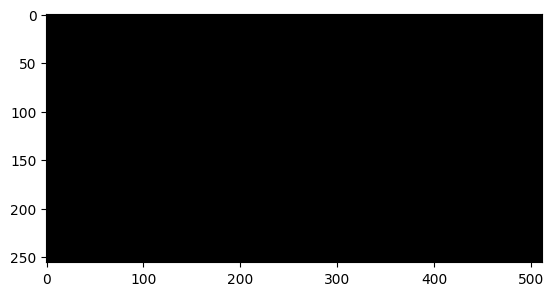

In [1]:
import matplotlib.pyplot as plt
import torch

h, w = 256, 512
ph = [[[0] * w for _ in range(h)] for _ in range(3)]
torch_ph = torch.Tensor(ph).to(torch.uint8)
plt.imshow(torch_ph.permute(1, 2, 0))

In [2]:
import torchvision
import torchvision.transforms.v2

In [5]:
import math
import numbers
import warnings
from typing import Any, Callable, Dict, List, Literal, Optional, Sequence, Tuple, Type, Union

import PIL.Image
import torch

from torchvision import transforms as _transforms
from torchvision.transforms.v2 import functional as F, InterpolationMode, Transform
from torchvision.transforms.v2._utils import _setup_size, query_size

class TFInceptionCrop(Transform):

    def __init__(
        self,
        size: Union[int, Sequence[int]],
        scale: Tuple[float, float] = (0.08, 1.0),
        ratio: Tuple[float, float] = (3.0 / 4.0, 4.0 / 3.0),
        interpolation: Union[InterpolationMode, int] = InterpolationMode.BILINEAR,
        antialias: Optional[bool] = True,
        max_attempts: int = 100,
    ) -> None:
        super().__init__()
        self.size = _setup_size(size, error_msg="Please provide only two dimensions (h, w) for size.")

        if not isinstance(scale, Sequence):
            raise TypeError("Scale should be a sequence")
        if not isinstance(ratio, Sequence):
            raise TypeError("Ratio should be a sequence")
        if (scale[0] > scale[1]) or (ratio[0] > ratio[1]):
            warnings.warn("Scale and ratio should be of kind (min, max)")

        self.scale = scale
        self.ratio = ratio
        self.interpolation = interpolation
        self.antialias = antialias
        self.max_attempts = max_attempts

        self._ratio = torch.tensor(self.ratio)

    def _get_params(self, flat_inputs: List[Any]) -> Dict[str, Any]:
        """Almost line-by-line translation of the core logic of
        tensorflow/core/kernels/image/sample_distorted_bounding_box_op.cc
        """
        original_height, original_width = query_size(flat_inputs)
        area = original_height * original_width

        ratio = self._ratio
        for _ in range(self.max_attempts):
            aspect_ratio = torch.empty(1).uniform_(
                ratio[0],  # type: ignore[arg-type]
                ratio[1],  # type: ignore[arg-type]
            ).item()

            min_area = self.scale[0] * area
            max_area = self.scale[1] * area

            min_height = round(math.sqrt(min_area / aspect_ratio))
            max_height = round(math.sqrt(max_area / aspect_ratio))

            # TODO(b/140767341): Rewrite the generation logic to be more tolerant
            # of floating point behavior.
            if round(max_height * aspect_ratio) > original_width:
                # We must find the smallest max_height satisfying
                # round(max_height * aspect_ratio) <= original_width:
                EPSILON = 0.0000001
                max_height = int((original_width + 0.5 - EPSILON) / aspect_ratio)
                # If due some precision issues, we still cannot guarantee
                # round(max_height * aspect_ratio) <= original_width, subtract 1 from
                # max height.
                if round(max_height * aspect_ratio) > original_width:
                    max_height -= 1

            max_height = min(max_height, original_height)
            min_height = min(min_height, max_height)

            # We need to generate a random number in the closed range
            # [min_height, max_height].
            height = torch.randint(min_height, max_height + 1, size=(1,)).item()
            width = round(height * aspect_ratio)

            # Let us not fail if rounding error causes the area to be
            # outside the constraints.
            # Try first with a slightly bigger rectangle first.
            area = width * height
            if area < min_area:
                height += 1
                width = round(height * aspect_ratio)
                area = width * height

            # Let us not fail if rounding error causes the area to be
            # outside the constraints.
            # Try first with a slightly smaller rectangle first.
            if area > max_area:
                height -= 1
                width = round(height * aspect_ratio)
                area = width * height

            # Now, we explored all options to rectify small rounding errors.
            # If the constraints can be satisfied: break out of the loop.
            if 0 < width <= original_width and 0 < height <= original_height and min_area <= area <= max_area:
                i = torch.randint(0, original_height - height + 1, size=(1,)).item()
                j = torch.randint(0, original_width - width + 1, size=(1,)).item()
                break
        else:
            # Fallback to the entire image
            width = original_width
            height = original_height
            i = j = 0

        return dict(top=i, left=j, height=height, width=width)

    def _transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        return self._call_kernel(
            F.resized_crop, inpt, **params, size=self.size, interpolation=self.interpolation, antialias=self.antialias
        )

In [6]:
torch_repo_crop = TFInceptionCrop(224, scale=(0.05, 1.0), ratio=(3/4, 4/3))
torch_repo_crop._get_params(torch_ph)

{'top': 62, 'left': 154, 'height': 125, 'width': 155}

In [7]:
import tqdm

In [8]:
h, w = 256, 512
torch_repo_ij_counts = [[0] * w for _ in range(h)]
torch_repo_hw_counts = [[0] * (w + 1) for _ in range(h + 1)]
N = 10000000
for _ in tqdm.tqdm(range(N)):
  i, j, h, w = torch_repo_crop._get_params(torch_ph).values()
  torch_repo_ij_counts[i][j] += 1
  torch_repo_hw_counts[h][w] += 1

100%|██████████| 10000000/10000000 [14:27<00:00, 11521.58it/s]


1316
[[1233.0, 1255.0, 1289.0, 1170.0, 1253.0, 1184.0, 1185.0, 1243.0, 1223.0, 1248.0, 1232.0, 1232.0, 1213.0, 1216.0, 1316.0, 1223.0, 1179.0, 1211.0, 1232.0, 1151.0, 1240.0, 1185.0, 1219.0, 1263.0, 1185.0, 1220.0, 1223.0, 1210.0, 1228.0, 1275.0, 1252.0, 1228.0, 1218.0, 1178.0, 1231.0, 1216.0, 1303.0, 1211.0, 1187.0, 1232.0, 1212.0, 1202.0, 1215.0, 1214.0, 1193.0, 1178.0, 1229.0, 1213.0, 1231.0, 1165.0, 1198.0, 1259.0, 1204.0, 1234.0, 1211.0, 1285.0, 1160.0, 1212.0, 1245.0, 1241.0, 1226.0, 1196.0, 1240.0, 1225.0, 1206.0, 1191.0, 1202.0, 1227.0, 1215.0, 1275.0, 1251.0, 1233.0, 1248.0, 1229.0, 1216.0, 1174.0, 1223.0, 1226.0, 1201.0, 1242.0, 1179.0, 1183.0, 1271.0, 1181.0, 1193.0, 1243.0, 1237.0, 1264.0, 1184.0, 1197.0, 1230.0, 1218.0, 1221.0, 1266.0, 1152.0, 1238.0, 1211.0, 1196.0, 1226.0, 1260.0, 1213.0, 1256.0, 1214.0, 1174.0, 1223.0, 1211.0, 1212.0, 1221.0, 1214.0, 1195.0, 1242.0, 1239.0, 1291.0, 1246.0, 1229.0, 1204.0, 1219.0, 1189.0, 1236.0, 1236.0, 1239.0, 1231.0, 1242.0, 1244.0, 1

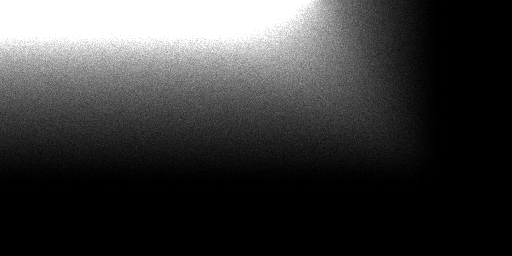

In [9]:
from PIL import Image
import numpy as np

def plot(counts, factor=1):
  h, w = len(counts), len(counts[0])
  maximum = max(max(row) for row in counts)
  print(maximum)
  b = [[float(counts[i][j]) * factor for j in range(w)] for i in range(h)]
  print(b)
  return Image.fromarray(np.array(b)).convert('L')

plot(torch_repo_ij_counts)

2579
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

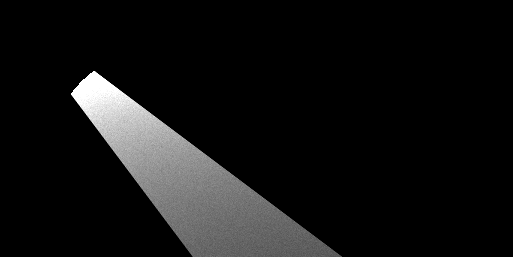

In [20]:
plot(torch_repo_hw_counts, 1/4)

In [11]:
torchvision.transforms.v2.RandomResizedCrop.get_params(torch_ph, scale=(0.05, 1.0), ratio=(3/4, 4/3))

(16, 40, 219, 256)

In [21]:
h, w = 256, 512
torch_ij_counts = [[0] * w for _ in range(h)]
torch_hw_counts = [[0] * (w + 1) for _ in range(h + 1)]
N = 10000000
for _ in tqdm.tqdm(range(N)):
  i, j, h, w = torchvision.transforms.v2.RandomResizedCrop.get_params(torch_ph, scale=(0.05, 1.0), ratio=(3/4, 4/3))
  torch_ij_counts[i][j] += 1
  torch_hw_counts[h][w] += 1

100%|██████████| 10000000/10000000 [18:25<00:00, 9043.90it/s]


15609
[[1739.0, 1712.0, 1664.0, 1688.0, 1779.0, 1696.0, 1692.0, 1642.0, 1671.0, 1659.0, 1682.0, 1651.0, 1712.0, 1694.0, 1666.0, 1673.0, 1725.0, 1671.0, 1699.0, 1705.0, 1688.0, 1715.0, 1716.0, 1701.0, 1659.0, 1656.0, 1699.0, 1670.0, 1678.0, 1738.0, 1761.0, 1684.0, 1682.0, 1696.0, 1692.0, 1680.0, 1704.0, 1685.0, 1719.0, 1709.0, 1674.0, 1730.0, 1639.0, 1748.0, 1727.0, 1614.0, 1724.0, 1773.0, 1750.0, 1708.0, 1733.0, 1599.0, 1689.0, 1677.0, 1725.0, 1660.0, 1718.0, 1612.0, 1707.0, 1698.0, 1725.0, 1706.0, 1728.0, 1698.0, 1727.0, 1731.0, 1694.0, 1646.0, 1735.0, 1680.0, 1680.0, 1677.0, 1668.0, 1681.0, 1715.0, 1745.0, 1834.0, 1740.0, 1662.0, 1693.0, 1692.0, 1719.0, 1697.0, 1726.0, 1749.0, 15609.0, 1723.0, 1692.0, 1688.0, 1643.0, 1708.0, 1681.0, 1680.0, 1649.0, 1721.0, 1727.0, 1750.0, 1661.0, 1726.0, 1697.0, 1666.0, 1718.0, 1606.0, 1672.0, 1661.0, 1645.0, 1664.0, 1666.0, 1652.0, 1665.0, 1740.0, 1716.0, 1700.0, 1679.0, 1698.0, 1696.0, 1737.0, 1729.0, 1717.0, 1719.0, 1712.0, 1656.0, 1701.0, 1712.0,

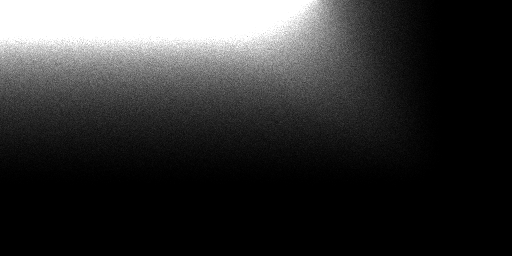

In [22]:
plot(torch_ij_counts)

14340
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

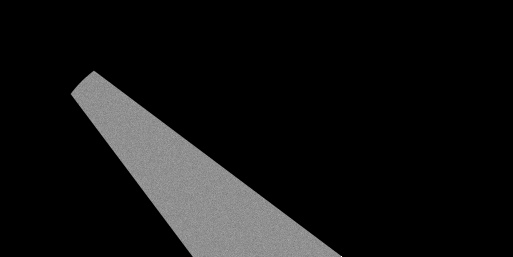

In [29]:
plot(torch_hw_counts, 1/4)

In [25]:
import tensorflow as tf
h, w = 256, 512
tf_ij_counts = [[0] * w for _ in range(h)]
tf_hw_counts = [[0] * (w + 1) for _ in range(h + 1)]
for _ in tqdm.tqdm(range(N)):
  begin, crop_size, _ = tf.image.sample_distorted_bounding_box(
        tf.convert_to_tensor([h, w, 1]),
        tf.zeros([0, 0, 4], tf.float32),
        area_range=[0.05, 1],
        min_object_covered=0,  # Don't enforce a minimum area.
        use_image_if_no_bounding_boxes=True)
  i, j, _ = begin.numpy()
  y, x, _ = crop_size.numpy()
  tf_ij_counts[i][j] += 1
  tf_hw_counts[y][x] += 1

100%|██████████| 10000000/10000000 [1:18:54<00:00, 2112.25it/s]


1546
[[1458.0, 1504.0, 1495.0, 1370.0, 1402.0, 1429.0, 1483.0, 1450.0, 1421.0, 1445.0, 1408.0, 1477.0, 1475.0, 1468.0, 1524.0, 1477.0, 1537.0, 1521.0, 1449.0, 1484.0, 1404.0, 1440.0, 1498.0, 1462.0, 1492.0, 1397.0, 1411.0, 1414.0, 1493.0, 1436.0, 1416.0, 1476.0, 1441.0, 1483.0, 1380.0, 1448.0, 1506.0, 1426.0, 1444.0, 1455.0, 1460.0, 1505.0, 1503.0, 1451.0, 1425.0, 1454.0, 1433.0, 1507.0, 1470.0, 1429.0, 1377.0, 1478.0, 1429.0, 1452.0, 1476.0, 1449.0, 1461.0, 1456.0, 1504.0, 1449.0, 1454.0, 1381.0, 1432.0, 1428.0, 1388.0, 1490.0, 1417.0, 1420.0, 1365.0, 1451.0, 1464.0, 1385.0, 1437.0, 1466.0, 1441.0, 1515.0, 1470.0, 1454.0, 1461.0, 1464.0, 1447.0, 1408.0, 1444.0, 1465.0, 1454.0, 1431.0, 1424.0, 1392.0, 1470.0, 1438.0, 1477.0, 1454.0, 1441.0, 1392.0, 1546.0, 1492.0, 1379.0, 1485.0, 1467.0, 1462.0, 1407.0, 1468.0, 1452.0, 1436.0, 1419.0, 1394.0, 1453.0, 1454.0, 1458.0, 1488.0, 1435.0, 1460.0, 1492.0, 1448.0, 1492.0, 1368.0, 1468.0, 1449.0, 1450.0, 1388.0, 1425.0, 1477.0, 1513.0, 1469.0, 1

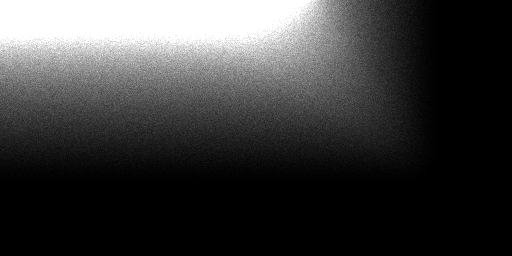

In [26]:
plot(tf_ij_counts)

2518
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

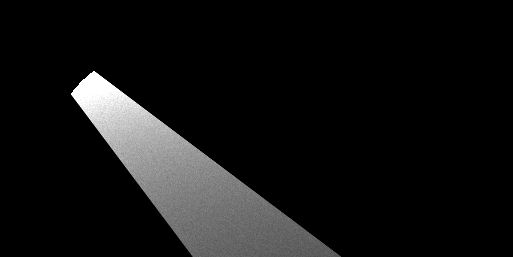

In [28]:
plot(tf_hw_counts, 1/4)